In [1]:
"""! pip install datasets
! pip install matplotlib
! pip install scikit-learn
! pip install spacy
! pip install nltk
! pip install pattern
! pip install wordcloud
! pip install gensim
! pip install xgboost
# ! python -m spacy download pt_core_news_sm
! python -m spacy download pt_core_news_lg"""

'! pip install datasets\n! pip install matplotlib\n! pip install scikit-learn\n! pip install spacy\n! pip install nltk\n! pip install pattern\n! pip install wordcloud\n! pip install gensim\n! pip install xgboost\n# ! python -m spacy download pt_core_news_sm\n! python -m spacy download pt_core_news_lg'

In [2]:
from sklearn.metrics import classification_report, f1_score, hamming_loss, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from nltk.stem import SnowballStemmer
from gensim.models import Word2Vec
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from datasets import load_dataset
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import vstack
import pandas as pd
import numpy as np
import warnings
import spacy
import nltk
import re

nltk.download('stopwords')

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/martapereira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Data Loading and Understanding**

In [3]:
dataset = load_dataset("higopires/RePro-categories-multilabel")

In [4]:
# Ver número de exemplos em cada divisão do dataset
for split in dataset.keys():
    print(f"{split}: {len(dataset[split])} examples")

train: 8002 examples
validation: 994 examples
test: 1007 examples


In [5]:
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

train_data = pd.DataFrame(train_dataset)
val_data = pd.DataFrame(val_dataset)
test_data = pd.DataFrame(test_dataset)

In [6]:
train_data.head()

,review_text,ENTREGA,OUTROS,PRODUTO,CONDICOESDERECEBIMENTO,INADEQUADA,ANUNCIO
0,"Aparelho muito bom, confiável e com valor aqui...",0,0,1,0,0,0
1,"A história é muito boa, porém o autor ""enrolou...",0,0,1,0,0,0
2,"Entrega rápida, produto muito bom Amei. Pratic...",1,0,1,0,0,0
3,Produto otimo so falta o carregador da maquina...,0,0,1,1,0,0
4,a proteção anti queda não é boa se cair de fr...,0,0,1,0,0,0


Checking the missing values

In [7]:
train_data.isnull().sum()

review_text               0
ENTREGA                   0
OUTROS                    0
PRODUTO                   0
CONDICOESDERECEBIMENTO    0
INADEQUADA                0
ANUNCIO                   0
dtype: int64

Example of some reviews

In [8]:
print(train_data["review_text"][2])

Entrega rápida, produto muito bom Amei. Praticidade


In [9]:
print(train_data["review_text"][7])

...................     ..........gdssdfhhbcxxxxvbjjnvvvvbbbbbvxfvhbbbnncftg


In [10]:
# check data type of review_text
print(type(train_data["review_text"][0]))
# check data type of label PRODUTO
print(type(train_data["PRODUTO"][0]))

<class 'str'>
<class 'numpy.int64'>


In [11]:
"""train_data['length'] = train_data['review_text'].apply(len)
train_data.head()"""

"train_data['length'] = train_data['review_text'].apply(len)\ntrain_data.head()"

In [12]:
# Obter as colunas (nomes dos labels)
columns = list(dataset["train"].features.keys())
labels = columns[1:]  # Excluindo 'review_text'

print("Labels:", labels)
print("Number of labels:", len(labels))

Labels: ['ENTREGA', 'OUTROS', 'PRODUTO', 'CONDICOESDERECEBIMENTO', 'INADEQUADA', 'ANUNCIO']
Number of labels: 6


In [13]:
# Label columns
label_cols = ['ENTREGA', 'OUTROS', 'PRODUTO', 'CONDICOESDERECEBIMENTO', 'INADEQUADA', 'ANUNCIO']

## **EDA**

{'PRODUTO': 6258, 'ENTREGA': 2488, 'OUTROS': 1885, 'CONDICOESDERECEBIMENTO': 1369, 'ANUNCIO': 699, 'INADEQUADA': 328}


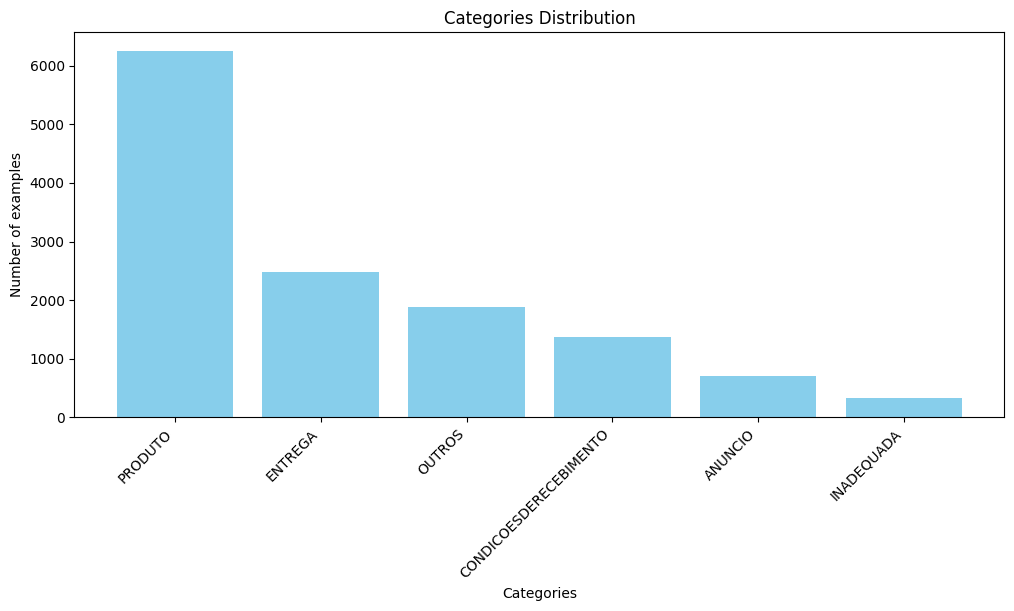

In [14]:
label_counts = train_data.iloc[:, 1:].sum()

# Ordenar por frequência
label_counts = dict(sorted(label_counts.items(), key=lambda item: item[1], reverse=True))

print(label_counts)

# Plotar gráfico
plt.figure(figsize=(12, 5))
plt.bar(label_counts.keys(), label_counts.values(), color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Categories")
plt.ylabel("Number of examples")
plt.title("Categories Distribution")
plt.show()

Number of labels per review distribution:
1    4188
2    2741
3     943
4     122
5       8
Name: count, dtype: int64


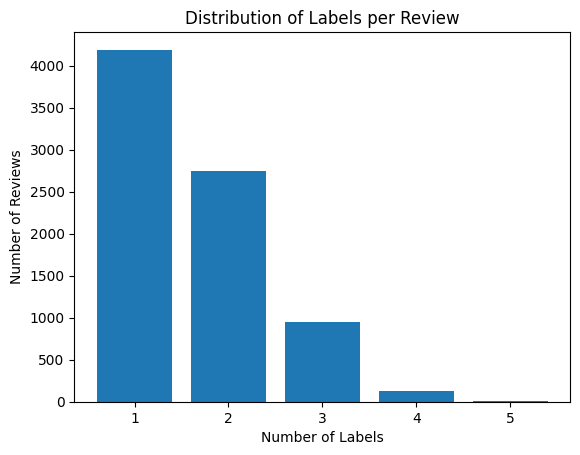

In [15]:
label_counts_per_review = train_data[label_cols].sum(axis=1)
print("Number of labels per review distribution:")
print(pd.Series(label_counts_per_review).value_counts())

plt.hist(label_counts_per_review, bins=range(1, 7), align='left', rwidth=0.8)
plt.title("Distribution of Labels per Review")
plt.xlabel("Number of Labels")
plt.ylabel("Number of Reviews")
plt.show()

* 4188 reviews have exactly 1 label
* 2741 reviews have exactly 2 labels
* 943 reviews have exactly 3 labels
* 122 reviews have exactly 4 labels
* 8 reviews have exactly 5 labels

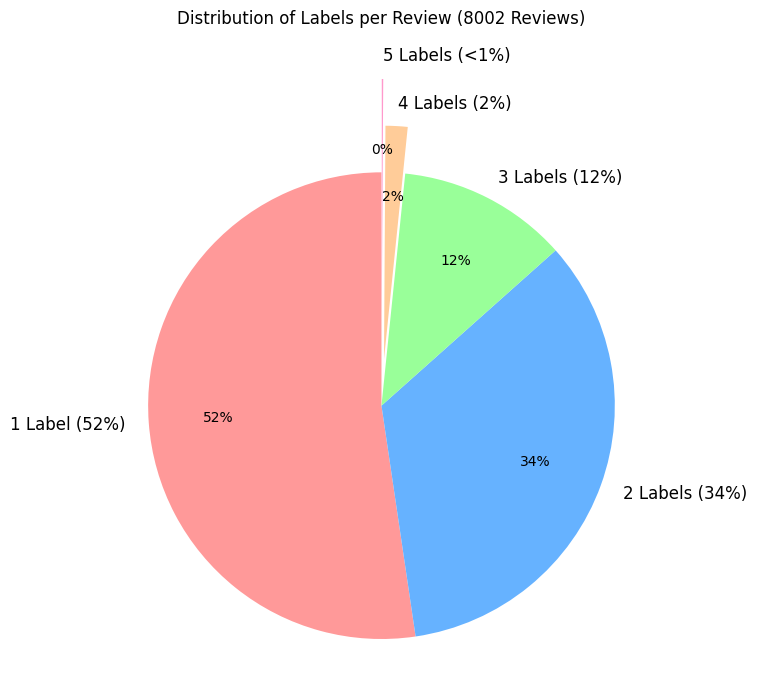

In [16]:
label_counts = label_counts_per_review.value_counts().values
total_reviews = 8002 # number of training examples
percentages = [count / total_reviews * 100 for count in label_counts]
labels = ['1 Label (52%)', '2 Labels (34%)', '3 Labels (12%)', '4 Labels (2%)', '5 Labels (<1%)']

# Create pie chart
plt.figure(figsize=(8, 8))
# Add explode to pull out small slices, and adjust label distance
explode = [0, 0, 0, 0.2, 0.4]  # Pull out 4 and 5 labels a bit
wedges, texts, autotexts = plt.pie(percentages, labels=labels, autopct='%1.0f%%', startangle=90,
                                   colors=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC'],
                                   explode=explode, labeldistance=1.1, pctdistance=0.7)

# Customize text for readability
for text in texts:
    text.set_fontsize(12)  # Bigger label text
for autotext in autotexts:
    autotext.set_fontsize(10)  # Bigger percentage text
    autotext.set_color('black')  # Black for contrast

plt.title("Distribution of Labels per Review (8002 Reviews)", pad=20)
plt.axis('equal')  # Keep it circular
plt.show()

In [17]:
text_lengths = [len(example["review_text"].split()) for example in dataset["train"]]

print(f"Average text length: {np.mean(text_lengths):.2f} words")
print(f"Maximum text length: {np.max(text_lengths)} words")
print(f"Minimum text length: {np.min(text_lengths)} words")

Average text length: 24.58 words
Maximum text length: 428 words
Minimum text length: 1 words


Raw Vocabulary Size: 12742
Most Common Words: [('o', 7032), ('e', 6464), ('a', 5831), ('de', 5458), ('não', 4924), ('produto', 4296), ('que', 4200), ('é', 3167), ('muito', 2923), ('com', 2743), ('do', 2700), ('um', 2196), ('para', 2114), ('no', 1504), ('da', 1501), ('mas', 1429), ('bom', 1426), ('em', 1342), ('na', 1325), ('entrega', 1306)]
Example of Rare Words: ['aquisitivo', 'gdssdfhhbcxxxxvbjjnvvvvbbbbbvxfvhbbbnncftg', 'genero', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'constatada', 'habilitada', 'opnar', 'oproduto', 'ceição', 'soares']


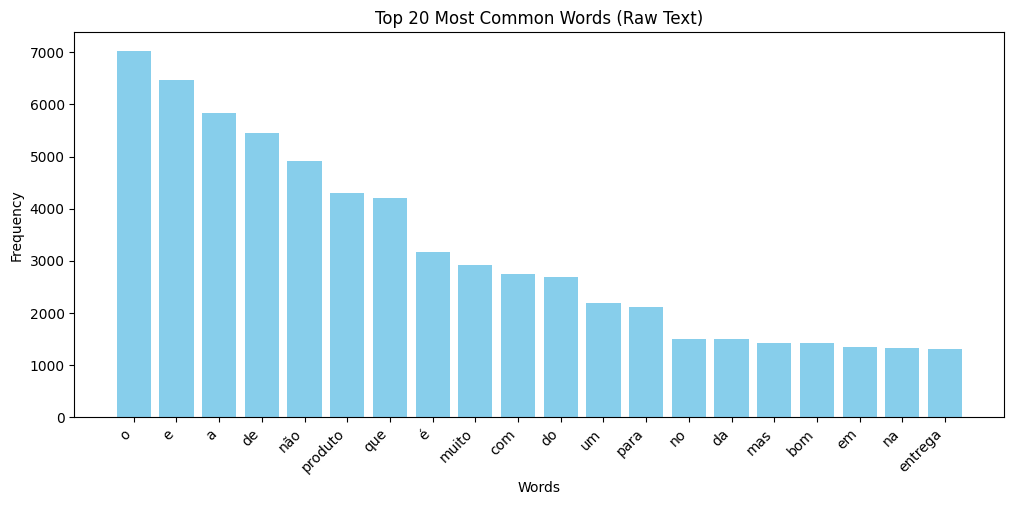

In [18]:
# Tokenize words from raw reviews
raw_texts = " ".join(train_data["review_text"]).lower()
raw_tokens = re.findall(r'\b\w+\b', raw_texts)  # Extract words
raw_vocab_size = len(set(raw_tokens))  # Unique words
raw_word_counts = Counter(raw_tokens)

# Most common words (before preprocessing)
common_raw_words = raw_word_counts.most_common(20)

# Least common words (words that appear once)
rare_raw_words = [word for word, count in raw_word_counts.items() if count == 1]

print(f"Raw Vocabulary Size: {raw_vocab_size}")
print(f"Most Common Words: {common_raw_words}")
print(f"Example of Rare Words: {rare_raw_words[:10]}")

# plot top 20 most common words
plt.figure(figsize=(12, 5))
plt.bar([word for word, count in common_raw_words], [count for word, count in common_raw_words], color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Common Words (Raw Text)")
plt.show()

## **Preprocessing**

In [19]:
# Load the Portuguese language model
nlp = spacy.load('pt_core_news_lg')

# Initialize the Snowball Stemmer for Portuguese
stemmer = SnowballStemmer("portuguese")

def preprocess_text(text, method="lemma"):
    """
    Preprocess text by applying lemmatization or stemming.

    Parameters:
    - text (str): Input text
    - method (str): "lemma" for lemmatization, "stem" for stemming

    Returns:
    - str: Preprocessed text
    """
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Tokenization and processing
    doc = nlp(text)

    if method == "lemma":
        tokens = [token.lemma_ for token in doc if not token.is_stop]
    elif method == "stem":
        tokens = [stemmer.stem(token.text) for token in doc if not token.is_stop]
    else:
        raise ValueError("Method must be 'lemma' or 'stem'")

    return ' '.join(tokens)

# Apply preprocessing with both methods to compare
train_data['lemmatized_reviews'] = train_data['review_text'].apply(lambda x: preprocess_text(x, method="lemma"))
train_data['stemmed_reviews'] = train_data['review_text'].apply(lambda x: preprocess_text(x, method="stem"))

val_data['lemmatized_reviews'] = val_data['review_text'].apply(lambda x: preprocess_text(x, method="lemma"))
val_data['stemmed_reviews'] = val_data['review_text'].apply(lambda x: preprocess_text(x, method="stem"))

test_data['lemmatized_reviews'] = test_data['review_text'].apply(lambda x: preprocess_text(x, method="lemma"))
test_data['stemmed_reviews'] = test_data['review_text'].apply(lambda x: preprocess_text(x, method="stem"))


In [20]:
print("Original:", train_data['review_text'].iloc[0])
print("Lemmatized:", train_data['lemmatized_reviews'].iloc[0])
print("Stemmed:", train_data['stemmed_reviews'].iloc[0])

Original: Aparelho muito bom, confiável e com valor aquisitivo em conta, ou seja: tudo que a massa precisa!
Lemmatized: aparelho confiável aquisitivo conta ser massa precisar
Stemmed: aparelh confiável aquisit cont sej mass precis


In [21]:
train_data.head()

,review_text,ENTREGA,OUTROS,PRODUTO,CONDICOESDERECEBIMENTO,INADEQUADA,ANUNCIO,lemmatized_reviews,stemmed_reviews
0,"Aparelho muito bom, confiável e com valor aqui...",0,0,1,0,0,0,aparelho confiável aquisitivo conta ser massa ...,aparelh confiável aquisit cont sej mass precis
1,"A história é muito boa, porém o autor ""enrolou...",0,0,1,0,0,0,história autor enrolar livro,histór autor enrol livr
2,"Entrega rápida, produto muito bom Amei. Pratic...",1,0,1,0,0,0,entregar rápido produto amar praticidade,entreg ráp produt ame pratic
3,Produto otimo so falta o carregador da maquina...,0,0,1,1,0,0,produto otimo so carregador maquina pequeno,produt otim so carreg maquin pequen
4,a proteção anti queda não é boa se cair de fr...,0,0,1,0,0,0,proteção anti queda cair frente tela,proteçã anti qued cair frent tel


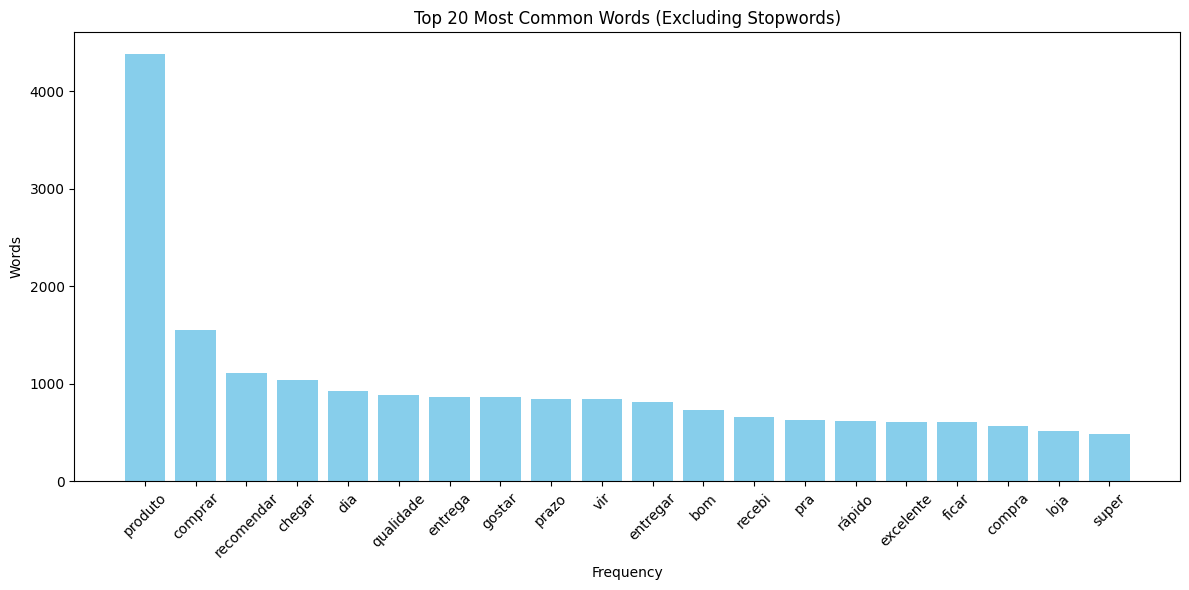

In [22]:
# Flatten all reviews into a single list of words
all_words = " ".join(train_data["lemmatized_reviews"]).split()

# Count word occurrences
word_counts = Counter(all_words)

# Get the 20 most common words
most_common_words = word_counts.most_common(20)

# Convert to DataFrame for easier plotting
word_most_common_df = pd.DataFrame(most_common_words, columns=["Word", "Count"])


plt.figure(figsize=(12, 6))
plt.bar(word_most_common_df["Word"], word_most_common_df["Count"], color="skyblue")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Common Words (Excluding Stopwords)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

In [23]:
# Get the 20 less common words
less_common_words = word_counts.most_common()[:-21:-1]

word_less_common_df = pd.DataFrame(less_common_words, columns=["Word", "Count"])

# Print words for reference
print(word_less_common_df)

# count the number of words that only appear once
words_appear_once = [word for word, count in word_counts.items() if count == 1]
print(f"Number of words that appear only once: {len(words_appear_once)}")

                                                 Word  Count
0                                                  ni      1
1                                          compátivel      1
2                                           chinamate      1
3                                     compraaquisição      1
4                                               grife      1
5                                              prazoe      1
6                                   confortávelbonito      1
7                                                Cabo      1
8                                        excelentepor      1
9   anunciadokkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...      1
10                                               conf      1
11                                              penso      1
12                                        instalausar      1
13                                            robusta      1
14                                         outramuito      1
15                      

In [24]:
# Compute vocabulary size
vocab_size = len(set(all_words))  # all_words is the list of words from previous step

print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 9957


Part Of Speech (POS) serves to identify nouns, verbs, etc., and filtered to keep only certain POS tags (e.g., nouns) before feature extraction. We didn't apply POS, because lemmatization already simplifies terms and multi-label needs flexible features (not just nouns or adjectives), so this technique might be redundant.

## **Feature Extraction**

## **1- TF-IDF**

### **1.1- Unigram TF-IDF Vectorization**

In [25]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit on the training data and transform it into TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['lemmatized_reviews'])
# Transform the validation and test data using the same vectorizer
X_val_tfidf = tfidf_vectorizer.transform(val_data['lemmatized_reviews'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['lemmatized_reviews'])

# Check the shape of the TF-IDF features, these are sparse matrices containing the TF-IDF features for the training, validation, and test sets, respectively.
# each row is a document and each column is a word
"""print("Training data shape:", X_train_tfidf.shape)
print("Validation data shape:", X_val_tfidf.shape)
print("Test data shape:", X_test_tfidf.shape, end="\n\n")"""

# Sum the TF-IDF scores for each word across all documents
tfidf_scores = np.asarray(X_train_tfidf.sum(axis=0)).flatten()

# Get the feature names (words in the vocabulary)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a dictionary of words and their corresponding TF-IDF scores
word_tfidf_scores = dict(zip(feature_names, tfidf_scores))

# Sort the words by their TF-IDF scores in descending order
sorted_words = sorted(word_tfidf_scores.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 words
print("Top 20 unigrams by TF-IDF score:")
for word, score in sorted_words[:20]:
    print(f"{word}: {score:.4f}")

Top 20 unigrams by TF-IDF score:
produto: 488.2262
recomendar: 234.1057
chegar: 203.3263
comprar: 199.9689
prazo: 194.0114
qualidade: 185.3566
gostar: 182.2771
entregar: 181.8631
entrega: 173.2043
rápido: 154.2068
excelente: 151.3629
bom: 146.1159
dia: 143.8600
recebi: 136.4783
vir: 136.1746
super: 119.6697
ótimo: 114.8176
atender: 106.3468
compra: 105.3768
pra: 98.0093


### **1.2- Bigram TF-IDF Vectorization**

In [26]:
# Define the TF-IDF vectorizer with unigrams and bigrams
tfidf_bigram = TfidfVectorizer(ngram_range=(2, 2))  # Unigrams + bigrams

# Fit and transform the training data
X_train_tfidf_bi = tfidf_bigram.fit_transform(train_data['lemmatized_reviews'])
# Transform the validation and test data
X_val_tfidf_bi = tfidf_bigram.transform(val_data['lemmatized_reviews'])
X_test_tfidf_bi = tfidf_bigram.transform(test_data['lemmatized_reviews'])

# Calculate the sum of TF-IDF scores for each feature (word/phrase)
tfidf_scores_bi = np.asarray(X_train_tfidf_bi.sum(axis=0)).flatten()
# Get the feature names (words/phrases)
feature_names_bi = tfidf_bigram.get_feature_names_out()
# Create a dictionary of words/phrases and their corresponding TF-IDF scores
word_tfidf_scores_bi = dict(zip(feature_names_bi, tfidf_scores_bi))
# Sort the words/phrases by their TF-IDF scores in descending order
sorted_words_bi = sorted(word_tfidf_scores_bi.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 unigrams and bigrams by TF-IDF score
print("\nTop 20 bigrams by TF-IDF score:")
for word, score in sorted_words_bi[:20]:
    print(f"{word}: {score:.4f}")


Top 20 bigrams by TF-IDF score:
recebi produto: 55.4152
chegar prazo: 55.0975
produto chegar: 49.3651
gostar produto: 47.2966
entregar prazo: 47.2189
produto entregar: 41.0208
atender expectativa: 37.7258
ótimo qualidade: 37.1043
produto excelente: 34.6375
bom produto: 33.2058
produto qualidade: 32.6299
produto ótimo: 32.1825
excelente produto: 30.1993
entregar rápido: 29.5193
super recomendar: 29.4634
produto atender: 28.9780
produto vir: 28.8988
super rápido: 28.6211
valer pena: 28.4338
comprar produto: 27.4269


### **1.3- Unigram + Bigram TF-IDF Vectorization**

In [27]:
def create_tfidf_features_uni_bi(train_texts, val_texts, test_texts, min_df=1, max_features=None):
    """
    Generate TF-IDF features with specified min_df and max_features.
    
    Parameters:
    - train_texts: Training data (e.g., train_data['lemmatized_reviews'])
    - val_texts: Validation data (e.g., val_data['lemmatized_reviews'])
    - test_texts: Test data (e.g., test_data['lemmatized_reviews'])
    - min_df: Minimum document frequency (default=2)
    - max_features: Maximum number of features (default=None, no limit)
    
    Returns:
    - X_train_tfidf, X_val_tfidf, X_test_tfidf: TF-IDF matrices
    - feature_names: List of feature names
    """
    # Define TF-IDF vectorizer with unigrams and bigrams
    tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=min_df, max_features=max_features)
    
    # Fit and transform training data
    X_train_tfidf = tfidf.fit_transform(train_texts)
    # Transform validation and test data
    X_val_tfidf = tfidf.transform(val_texts)
    X_test_tfidf = tfidf.transform(test_texts)
    
    # Get feature names and scores
    feature_names = tfidf.get_feature_names_out()
    tfidf_scores = np.asarray(X_train_tfidf.sum(axis=0)).flatten()
    word_tfidf_scores = dict(zip(feature_names, tfidf_scores))
    sorted_words = sorted(word_tfidf_scores.items(), key=lambda x: x[1], reverse=True)
    
    
    print(f"Feature space size: {X_train_tfidf.shape[1]}")
    return X_train_tfidf, X_val_tfidf, X_test_tfidf, feature_names, sorted_words[:20]

# Example usage (you can change parameters here)
X_train_tfidf_bi, X_val_tfidf_bi, X_test_tfidf_bi, feature_names_bi, sorted_words = create_tfidf_features_uni_bi(
    train_data['lemmatized_reviews'],
    val_data['lemmatized_reviews'],
    test_data['lemmatized_reviews'],
    min_df=1,  # Change this to 2, 3, etc.
    max_features=5000  # Change to 5000, 8000, or None
)

# Print top 20 terms
print(f"\nTop 20 unigrams + bigrams by TF-IDF score")
for word, score in sorted_words[:20]:
    print(f"{word}: {score:.4f}")

Feature space size: 5000

Top 20 unigrams + bigrams by TF-IDF score
produto: 397.9442
recomendar: 184.9531
comprar: 181.4826
chegar: 162.0091
gostar: 155.7969
qualidade: 146.8700
prazo: 144.8143
entregar: 140.2032
entrega: 133.6801
bom: 124.6411
dia: 122.2652
vir: 121.7276
excelente: 117.9173
rápido: 116.5107
recebi: 114.0214
super: 95.8461
pra: 91.9058
ficar: 89.7605
ótimo: 89.1564
atender: 87.7731


There's only single words in the top 20 TF-IDF scores for unigrams + bigrams, because the unigrams have higher TF-IDF scores compared to the bigrams. This can happen if the unigrams are more frequent or carry more weight in the dataset.

Why unigrams + bigrams? Unigrams capture individual word importance, while bigrams preserve some context (e.g., "não entregue" might indicate a delivery issue better than "não" or "entregue" alone). Since reviews are short (avg. 24.58 words), bigrams add value without overwhelming the feature space.

For word distribution, we choose TF-IDF with unigrams + bigrams (ngram_range=(1, 2), 5000 features) as it captures both dominant single words (e.g., "produto": 397.94) and contextual phrases (e.g., "chegar prazo") in the RePro dataset. This reflects the mix of 52% single-label and 48% multi-label reviews, providing a comprehensive view of key terms without relying on model performance.

In [28]:
label_names = ['ENTREGA', 'OUTROS', 'PRODUTO', 'CONDICOESDERECEBIMENTO', 'INADEQUADA', 'ANUNCIO']

y_train = train_data[label_names].to_numpy()
y_val = val_data[label_names].to_numpy()
y_test = test_data[label_names].to_numpy()
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

y_train shape: (8002, 6)
y_val shape: (994, 6)
y_test shape: (1007, 6)


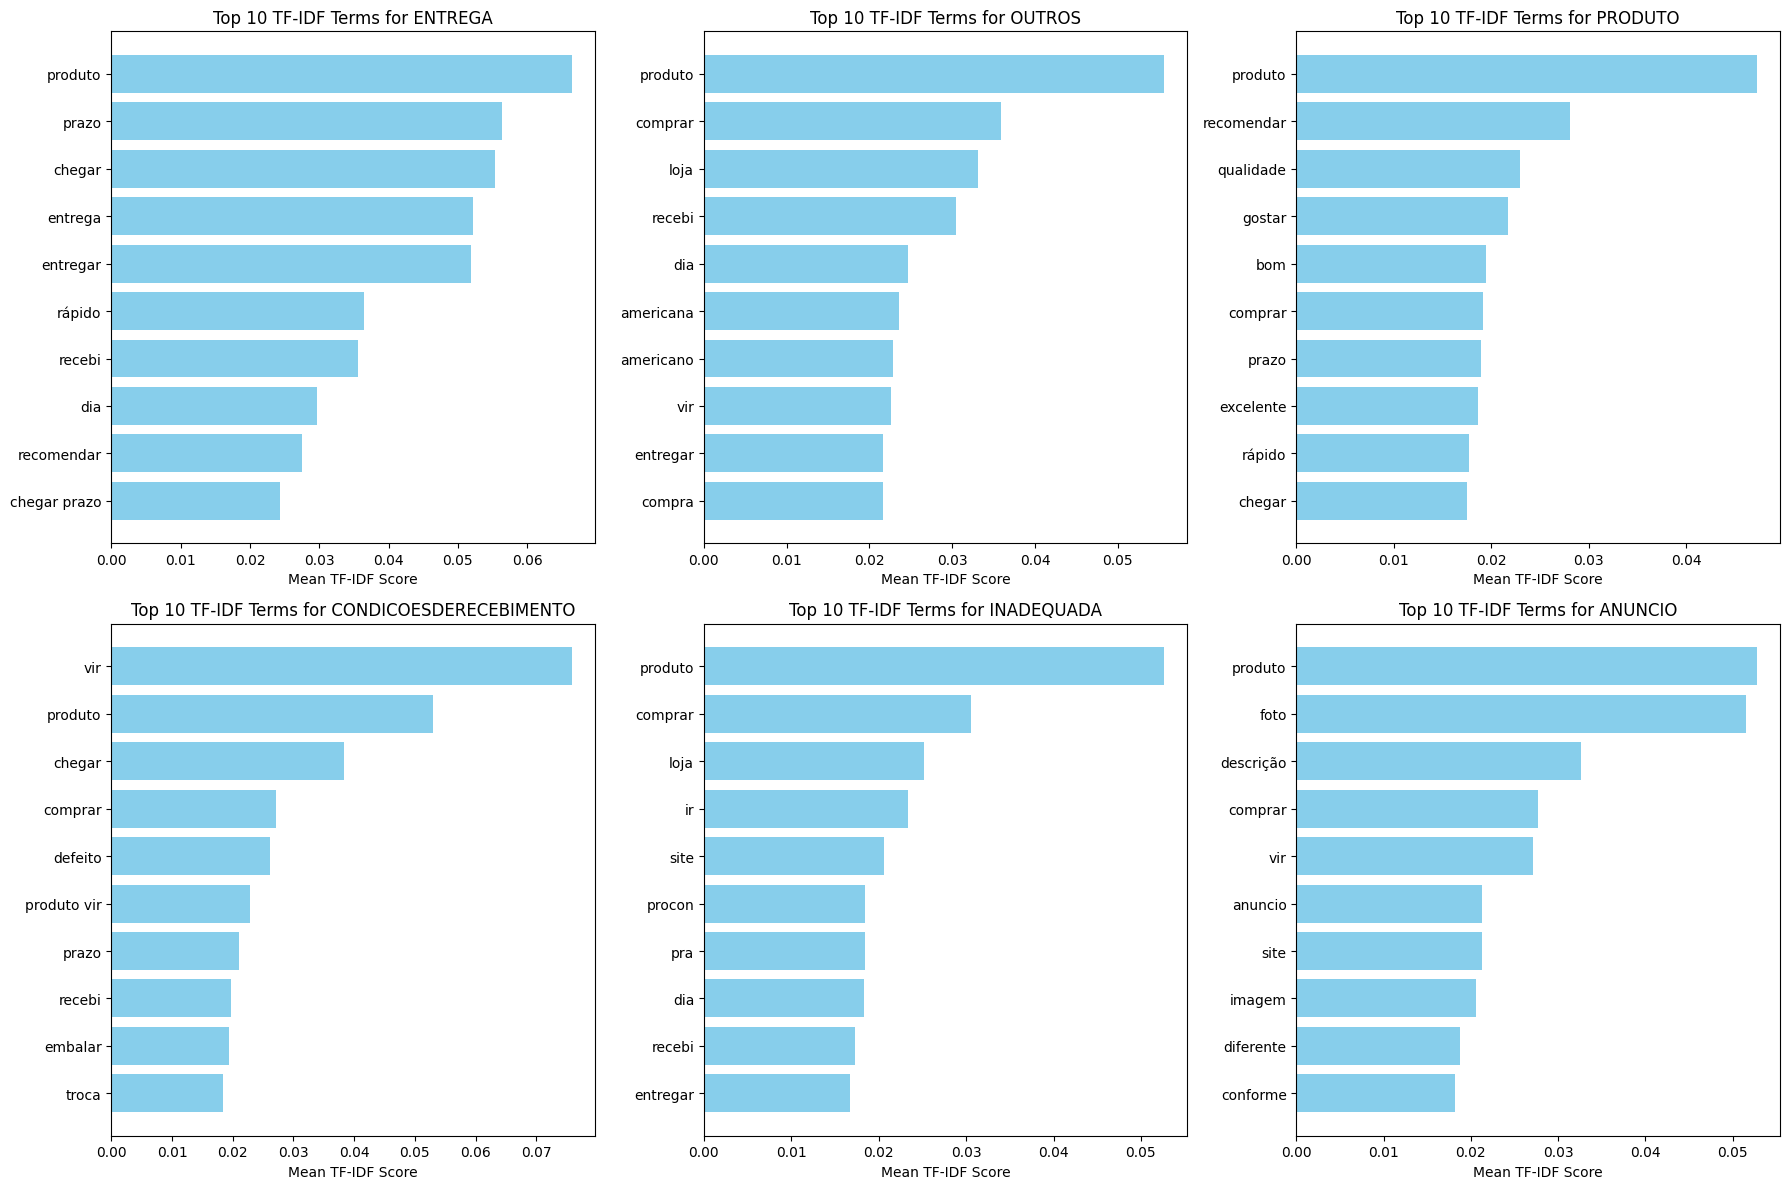

In [29]:
n_top = 10  # Number of top terms to show per label
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2x3 grid for 6 labels
axes = axes.flatten()

for i, label in enumerate(label_names):
    # Indices of reviews where this label is true (1)
    label_indices = np.where(y_train[:, i] == 1)[0]
    # Average TF-IDF scores for those reviews
    label_tfidf = X_train_tfidf_bi[label_indices].mean(axis=0).A1  # Convert sparse to 1D array
    # Get top N terms
    top_indices = np.argsort(label_tfidf)[-n_top:][::-1]  # Sort descending
    top_terms = feature_names_bi[top_indices]
    top_scores = label_tfidf[top_indices]

    # Step 5: Plot horizontal bar chart
    axes[i].barh(top_terms, top_scores, color='skyblue')
    axes[i].set_title(f'Top {n_top} TF-IDF Terms for {label}')
    axes[i].set_xlabel('Mean TF-IDF Score')
    axes[i].invert_yaxis()  # Highest score at top

# Adjust layout and display
plt.tight_layout()
plt.show()

### Feature Space

In [30]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1))  # Unigrams
X = vectorizer.fit_transform(train_data['lemmatized_reviews'])
print("Feature space size:", len(vectorizer.get_feature_names_out()))

Feature space size: 9824


In [31]:
vectorizer = TfidfVectorizer(ngram_range=(2, 2))  # Unigrams + bigrams
X = vectorizer.fit_transform(train_data['lemmatized_reviews'])
print("Feature space size:", len(vectorizer.get_feature_names_out()))

Feature space size: 59291


In [32]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))  # Unigrams and bigrams
X = vectorizer.fit_transform(train_data['lemmatized_reviews'])
print("Feature space size:", len(vectorizer.get_feature_names_out()))

Feature space size: 69115


In [33]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2)  # Unigrams and bigrams only keeping the terms that occur more than 2 times
X = vectorizer.fit_transform(train_data['lemmatized_reviews'])
print("Feature space size:", len(vectorizer.get_feature_names_out()))

Feature space size: 11400


In [34]:
vectorizer = TfidfVectorizer(max_features=10000 ,ngram_range=(1, 2))  # Unigrams and bigrams with maximum number of features
X = vectorizer.fit_transform(train_data['lemmatized_reviews'])
print("Feature space size:", len(vectorizer.get_feature_names_out()))

Feature space size: 10000


After applying TF-IDF vectorization with unigrams and bigrams our dataset, after preprocessing and vectorization, has generated a vocabulary of 69115 unique features (terms can be unigrams or bigrams).


min_df=2 -> 11400\
min_df=3 -> 6142


This is the dimensionality of our feature space—each review is represented as a sparse vector with 69115 possible positions, where most values are zero (since a single review uses only a tiny fraction of the vocabulary).

Our feature space is much larger than our sample size, this can lead to sparsity, where most feature values are zero, and potentially overfitting if not handled carefully. To address this high dimensionality and reduce noise from rare terms, we set min_df=2 in the TfidfVectorizer, excluding terms that appear in fewer than two reviews. This reduced the feature space to 11400 features, making it more manageable while retaining meaningful unigrams and bigrams. This adjustment helps mitigate sparsity and overfitting by focusing the model on terms with broader relevance across the dataset, balancing computational efficiency and classification performance

TF-IDF is sparse—each review is a vector of length equal to the feature space (e.g., 11,400), but most entries are zero. It’s frequency-based and doesn’t capture semantic relationships (e.g., "atraso" and "demora" are treated as unrelated unless they co-occur exactly).

**Benefits vs. TF-IDF**
* Feature Space Reduction:
TF-IDF: 69,115 → 11,400 → 10,000/5,000 (still sparse).
Word2Vec/Doc2Vec: 100 or 300 dims (dense). This slashes dimensionality by orders of magnitude, reducing sparsity and potentially overfitting—crucial with only 8002 samples.
* Semantic Understanding:
TF-IDF misses relationships (e.g., "defeito" and "estragado" are separate). Embeddings group similar terms, which could boost performance on short reviews (avg. 24.58 words) with varied phrasing.
* Imbalance Handling:
Your labels are imbalanced (PRODUTO: 6258, INADEQUADA: 328). Embeddings might help rare labels if synonyms or related terms (e.g., "falsificado," "inadequado") align in vector space.

**Risks**
* Data Size: 8002 reviews is modest for training embeddings from scratch. Pre-trained Word2Vec (e.g., Portuguese FastText) mitigates this, but Doc2Vec relies on your data alone.
* Complexity: Adds a step vs. TF-IDF, and averaging Word2Vec might dilute multi-label signals (e.g., ENTREGA + PRODUTO in one review).
* Performance: May not beat TF-IDF if your reviews are keyword-driven (e.g., "atraso" explicitly signals ENTREGA).

## **2- Word2Vec**

In [35]:
def tokenize(text):
    doc = nlp(text)
    return [token.text.lower() for token in doc if not token.is_stop and token.is_alpha]

train_tokens = [tokenize(text) for text in train_data["review_text"]]

# Treinar Word2Vec 
w2v_model = Word2Vec(sentences=train_tokens, vector_size=300, window=5, min_count=1, workers=4)

# Função para vetorizar uma revisão
def get_w2v_vector(text, model):
    tokens = tokenize(text)
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

# Aplicar a treino e validação
X_train_w2v = np.array([get_w2v_vector(text, w2v_model) for text in train_data["review_text"]])
X_val_w2v = np.array([get_w2v_vector(text, w2v_model) for text in val_data["review_text"]])

print("Word2Vec features:")
print("Training data:", X_train_w2v[:10])

Word2Vec features:
Training data: [[-0.14634827  0.24421802  0.06967496 ... -0.08306288  0.21886978
  -0.05117045]
 [-0.06800796  0.11685906  0.03146379 ... -0.03799155  0.10352755
  -0.02521945]
 [-0.14223863  0.34789911  0.07729225 ... -0.12568219  0.3025136
  -0.10784312]
 ...
 [-0.00128908 -0.00131401 -0.00294971 ... -0.00229093  0.00322753
  -0.00061842]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [36]:
print(X_train_tfidf_bi.shape)
print(X_train_w2v.shape)

(8002, 5000)
(8002, 300)


## **3-Combination of TF-IDF with Word2Vec**

In [37]:
def combine_tfidf_w2v(tfidf_matrix, w2v_matrix, method="concat"):
    """
    Combine TF-IDF and Word2Vec features.
    
    Parameters:
    - tfidf_matrix: TF-IDF feature matrix (sparse or dense)
    - w2v_matrix: Word2Vec feature matrix (dense)
    - method: "concat" for simple concatenation, "weighted" for TF-IDF-weighted Word2Vec
    
    Returns:
    - Combined feature matrix
    """
    if method == "concat":
        tfidf_matrix = tfidf_matrix.toarray()
        return np.hstack((tfidf_matrix, w2v_matrix))
    else:
        raise ValueError("Method must be 'concat' or 'weighted'")

X_train_combined = combine_tfidf_w2v(X_train_tfidf_bi, X_train_w2v, method="concat")
X_val_combined = combine_tfidf_w2v(X_val_tfidf_bi, X_val_w2v, method="concat")

print("Combined feature shape (train):", X_train_combined.shape)  # (8002, 5300) = 5000 TF-IDF + 300 W2V
print("Combined feature shape (val):", X_val_combined.shape)

Combined feature shape (train): (8002, 5300)
Combined feature shape (val): (994, 5300)


## **Models Training and Evaluation**

``One-vs-Rest (OvR)`` não é um classificador em si, mas uma estratégia para transformar classificadores binários (como Naive Bayes e Regressão Logística) em modelos que suportam multi-label ou multi-classe.

O ``Multinomial Naive Bayes (MultinomialNB)`` é um modelo estatístico ideal para classificação de texto porque:

✅ Lida bem com representações baseadas em frequência, como o TF-IDF.\
✅ É eficiente e rápido, pois calcula probabilidades de forma simples.\
✅ Funciona bem para problemas onde as palavras aparecem independentemente, como em reviews de produtos.


### Razão da Escolha das Métricas de Avaliação

Na classificação multi-label, onde cada amostra pode ter múltiplos rótulos e há desbalanceamento (e.g., PRODUTO: 782 vs. INADEQUADA: 42 no validation), usamos **Macro F1**, **Micro F1** e **Hamming Loss** para capturar diferentes aspectos do desempenho do modelo:

- **Macro F1**: Dá peso igual a cada rótulo, destacando o desempenho em rótulos raros, essencial para balanceamento.
- **Micro F1**: Avalia o desempenho global, agregando predições e refletindo a força em rótulos frequentes.
- **Hamming Loss**: Mede a fração de erros por rótulo, oferecendo uma visão granular da consistência.

Essas métricas juntas avaliam equilíbrio (Macro F1), desempenho geral (Micro F1) e erro médio (Hamming Loss)

In [38]:
# Function to train and evaluate the baseline classifier
def evaluate_baseline(X_train, X_val, y_train, y_val, label_names, config_name):
    baseline_clf = OneVsRestClassifier(MultinomialNB())
    baseline_clf.fit(X_train, y_train)
    y_pred = baseline_clf.predict(X_val)
    
    print(f"\n=== Baseline Results for {config_name} ===")
    print("Relatório de Classificação por Rótulo:")
    print(classification_report(y_val, y_pred, target_names=label_names))
    
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    micro_f1 = f1_score(y_val, y_pred, average='micro')
    hamming_value = hamming_loss(y_val, y_pred)
    
    print("\nMétricas Gerais:")
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Micro F1: {micro_f1:.4f}")
    print(f"Hamming Loss: {hamming_value:.4f}")
    return macro_f1, micro_f1, hamming_value

# Função para avaliar modelos 
def evaluate_model(X_train, X_val, y_train, y_val, model_name, classifier):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_val)
    
    print(f"\n=== {model_name} ===")
    print("Relatório de Classificação por Rótulo:")
    print(classification_report(y_val, y_pred, target_names=label_names))
    
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    micro_f1 = f1_score(y_val, y_pred, average='micro')
    hamming_value = hamming_loss(y_val, y_pred)
    
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Micro F1: {micro_f1:.4f}")
    print(f"Hamming Loss: {hamming_value:.4f}")
    return macro_f1, micro_f1, hamming_value, y_pred

### Baseline Classifier - Naive Bayes

In [39]:
from sklearn.preprocessing import MinMaxScaler

# List of configurations to test
configs = [
    {'min_df': 1, 'max_features': None, 'name': 'original'},
    {'min_df': 2, 'max_features': None, 'name': 'min_df=2 -> features = 11400'},
    {'min_df': 3, 'max_features': None, 'name': 'min_df=3 -> features = 6142'},
    {'min_df': 1, 'max_features': 7000, 'name': 'max_features=7000'},
    {'min_df': 1, 'max_features': 5000, 'name': 'max_features=5000'}
]

# Dictionary to store results
results = {}

# Loop through configurations
for config in configs:
    min_df = config['min_df']
    max_features = config['max_features']
    config_name = config['name']
    # print(f"\n\n=== Testing Configuration: {config_name} ===")
    
    # Generate TF-IDF features
    tfidf_result = create_tfidf_features_uni_bi(
        train_data['lemmatized_reviews'],
        val_data['lemmatized_reviews'],
        test_data['lemmatized_reviews'],
        min_df=min_df,
        max_features=max_features
    )
    
    # Unpack return values
    X_train_tfidf_bi, X_val_tfidf_bi, X_test_tfidf_bi, feature_names_bi, sorted_words = tfidf_result
    
    # Evaluate baseline classifier
    macro_f1, micro_f1, hamming = evaluate_baseline(
        X_train_tfidf_bi, X_val_tfidf_bi, y_train, y_val, label_names, config_name
    )
    
    # Store results for tf-idf
    results[f"{config_name}(TF-IDF)"] = {'macro_f1': macro_f1, 'micro_f1': micro_f1, 'hamming_loss': hamming}

    # Generate Word2Vec features
    X_train_w2v = np.array([get_w2v_vector(text, w2v_model) for text in train_data['lemmatized_reviews']])
    X_val_w2v = np.array([get_w2v_vector(text, w2v_model) for text in val_data['lemmatized_reviews']])
    X_test_w2v = np.array([get_w2v_vector(text, w2v_model) for text in test_data['lemmatized_reviews']])
    
    # Normalize Word2Vec features to non-negative values
    scaler = MinMaxScaler()
    X_train_w2v = scaler.fit_transform(X_train_w2v)
    X_val_w2v = scaler.transform(X_val_w2v)
    X_test_w2v = scaler.transform(X_test_w2v)

    # Evaluate baseline classifier with Word2Vec
    macro_f1, micro_f1, hamming = evaluate_baseline(
        X_train_w2v, X_val_w2v, y_train, y_val, label_names, f"{config_name} (Word2Vec)"
    )
    
    # Store results for Word2Vec
    results[f"{config_name} (Word2Vec)"] = {'macro_f1': macro_f1, 'micro_f1': micro_f1, 'hamming_loss': hamming}
    
    # Combine TF-IDF and Word2Vec features
    X_train_combined = combine_tfidf_w2v(X_train_tfidf_bi, X_train_w2v, method="concat")
    X_val_combined = combine_tfidf_w2v(X_val_tfidf_bi, X_val_w2v, method="concat")
    X_test_combined = combine_tfidf_w2v(X_test_tfidf_bi, X_test_w2v, method="concat")
    
    # Evaluate baseline classifier with TF-IDF + Word2Vec
    macro_f1, micro_f1, hamming = evaluate_baseline(
        X_train_combined, X_val_combined, y_train, y_val, label_names, f"{config_name} (TF-IDF + Word2Vec)"
    )
    
    # Store results for TF-IDF + Word2Vec
    results[f"{config_name}(TF-IDF + Word2Vec)"] = {'macro_f1': macro_f1, 'micro_f1': micro_f1, 'hamming_loss': hamming}

# Print summary of results
print("\n=== Summary of Baseline Results ===")
for config_name, metrics in results.items():
    print(f"{config_name}: Macro F1={metrics['macro_f1']:.4f}, Micro F1={metrics['micro_f1']:.4f}, Hamming Loss={metrics['hamming_loss']:.4f}")

Feature space size: 69115

=== Baseline Results for original ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.97      0.68      0.80       311
                OUTROS       0.95      0.17      0.29       235
               PRODUTO       0.82      1.00      0.90       782
CONDICOESDERECEBIMENTO       1.00      0.01      0.01       171
            INADEQUADA       0.00      0.00      0.00        42
               ANUNCIO       0.00      0.00      0.00        88

             micro avg       0.85      0.63      0.73      1629
             macro avg       0.62      0.31      0.33      1629
          weighted avg       0.82      0.63      0.63      1629
           samples avg       0.85      0.72      0.76      1629


Métricas Gerais:
Macro F1: 0.3336
Micro F1: 0.7264
Hamming Loss: 0.1306

=== Baseline Results for original (Word2Vec) ===
Relatório de Classificação por Rótulo:
                        pre

### Other classifiers
##### 1. Fine-tuned Logistic Regression
* TF-IDF

In [40]:
C_values = [0.01, 0.1, 1.0, 10.0]
results = {}
train_results = [] # store results for training set to plot at the end and compare

for C in C_values:
    model_logreg = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_features=5000)),
        ('Logistic Regression', OneVsRestClassifier(LogisticRegression(
            C=C, max_iter=1000, random_state=42, class_weight='balanced')))
    ])
    
    # Usar evaluate_model para treinar e avaliar
    macro_f1, micro_f1, hamming, _ = evaluate_model(
        train_data['lemmatized_reviews'],  # Texto bruto de treino
        val_data['lemmatized_reviews'],    # Texto bruto de validação
        y_train,
        y_val,
        f"Logistic Regression (TF-IDF, C={C})",
        model_logreg
    )
    
    # Armazenar resultados
    results[C] = {'Macro F1': macro_f1, 'Micro F1': micro_f1, 'Hamming Loss': hamming}

# Find and print the best C based on Macro F1
best_C = max(results, key=lambda x: results[x]['Macro F1'])

train_results.append({
    'Model': 'Logistic Regression',
    'Feature Set': 'TF-IDF',
    'Macro F1': results[best_C]['Macro F1'],
    'Micro F1': results[best_C]['Micro F1'],
    'Hamming Loss': results[best_C]['Hamming Loss']
})

print(f"\n=== Best C Value ===")
print(f"Best C: {best_C} with Macro F1={results[best_C]['Macro F1']:.4f}, "
      f"Micro F1={results[best_C]['Micro F1']:.4f}, Hamming Loss={results[best_C]['Hamming Loss']:.4f}")


=== Logistic Regression (TF-IDF, C=0.01) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.91      0.85      0.88       311
                OUTROS       0.67      0.71      0.69       235
               PRODUTO       0.93      0.91      0.92       782
CONDICOESDERECEBIMENTO       0.69      0.71      0.70       171
            INADEQUADA       0.17      0.69      0.27        42
               ANUNCIO       0.74      0.82      0.78        88

             micro avg       0.78      0.84      0.81      1629
             macro avg       0.68      0.78      0.70      1629
          weighted avg       0.83      0.84      0.83      1629
           samples avg       0.83      0.87      0.83      1629

Macro F1: 0.7045
Micro F1: 0.8059
Hamming Loss: 0.1102

=== Logistic Regression (TF-IDF, C=0.1) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

    

* Word2Vec

In [41]:
# Logistic Regression com Word2Vec
C_values = [0.01, 0.1, 1.0, 10.0]
results_w2v_logreg = {}
for C in C_values:
    model_logreg_w2v = OneVsRestClassifier(LogisticRegression(C=C, max_iter=1000, random_state=42, class_weight='balanced'))
    macro_f1, micro_f1, hamming, _ = evaluate_model(X_train_w2v, X_val_w2v, y_train, y_val, 
                                                 f"Logistic Regression (Word2Vec, C={C})", model_logreg_w2v)
    results_w2v_logreg[C] = {'Macro F1': macro_f1, 'Micro F1': micro_f1, 'Hamming Loss': hamming}

best_C_w2v = max(results_w2v_logreg, key=lambda x: results_w2v_logreg[x]['Macro F1'])

train_results.append({
    'Model': 'Logistic Regression',
    'Feature Set': 'Word2Vec',
    'Macro F1': results_w2v_logreg[best_C_w2v]['Macro F1'],
    'Micro F1': results_w2v_logreg[best_C_w2v]['Micro F1'],
    'Hamming Loss': results_w2v_logreg[best_C_w2v]['Hamming Loss']
})

print(f"\n=== Best C Value (Word2Vec) ===")
print(f"Best C: {best_C_w2v} with Macro F1={results_w2v_logreg[best_C_w2v]['Macro F1']:.4f}, "
      f"Micro F1={results_w2v_logreg[best_C_w2v]['Micro F1']:.4f}, Hamming Loss={results_w2v_logreg[best_C_w2v]['Hamming Loss']:.4f}")



=== Logistic Regression (Word2Vec, C=0.01) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.55      0.73      0.63       311
                OUTROS       0.42      0.66      0.51       235
               PRODUTO       0.91      0.78      0.84       782
CONDICOESDERECEBIMENTO       0.26      0.63      0.36       171
            INADEQUADA       0.05      0.38      0.08        42
               ANUNCIO       0.12      0.74      0.21        88

             micro avg       0.43      0.73      0.54      1629
             macro avg       0.39      0.65      0.44      1629
          weighted avg       0.64      0.73      0.65      1629
           samples avg       0.49      0.76      0.56      1629

Macro F1: 0.4404
Micro F1: 0.5415
Hamming Loss: 0.3357

=== Logistic Regression (Word2Vec, C=0.1) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support



* Combination

In [42]:
# Logistic Regression com Combinação
results_combined_logreg = {}
for C in C_values:
    model_logreg_combined = OneVsRestClassifier(LogisticRegression(C=C, max_iter=1000, random_state=42, class_weight='balanced'))
    macro_f1, micro_f1, hamming, _ = evaluate_model(X_train_combined, X_val_combined, y_train, y_val, 
                                                 f"Logistic Regression (TF-IDF + Word2Vec, C={C})", model_logreg_combined)
    results_combined_logreg[C] = {'Macro F1': macro_f1, 'Micro F1': micro_f1, 'Hamming Loss': hamming}

best_C_combined = max(results_combined_logreg, key=lambda x: results_combined_logreg[x]['Macro F1'])

train_results.append({
    'Model': 'Logistic Regression',
    'Feature Set': 'TF-IDF + Word2Vec',
    'Macro F1': results_combined_logreg[best_C_combined]['Macro F1'],
    'Micro F1': results_combined_logreg[best_C_combined]['Micro F1'],
    'Hamming Loss': results_combined_logreg[best_C_combined]['Hamming Loss']
})

print(f"\n=== Best C Value (TF-IDF + Word2Vec) ===")
print(f"Best C: {best_C_combined} with Macro F1={results_combined_logreg[best_C_combined]['Macro F1']:.4f}, "
      f"Micro F1={results_combined_logreg[best_C_combined]['Micro F1']:.4f}, Hamming Loss={results_combined_logreg[best_C_combined]['Hamming Loss']:.4f}")



=== Logistic Regression (TF-IDF + Word2Vec, C=0.01) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.61      0.77      0.68       311
                OUTROS       0.50      0.68      0.57       235
               PRODUTO       0.92      0.84      0.88       782
CONDICOESDERECEBIMENTO       0.40      0.73      0.52       171
            INADEQUADA       0.05      0.36      0.09        42
               ANUNCIO       0.22      0.84      0.35        88

             micro avg       0.54      0.78      0.64      1629
             macro avg       0.45      0.70      0.51      1629
          weighted avg       0.68      0.78      0.71      1629
           samples avg       0.61      0.80      0.65      1629

Macro F1: 0.5146
Micro F1: 0.6363
Hamming Loss: 0.2425

=== Logistic Regression (TF-IDF + Word2Vec, C=0.1) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1

##### 2. Linear Support Vector Classification (SVC)

* TF-IDF

In [43]:
model_svc = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_features=5000)),
    ('Linear SVM', OneVsRestClassifier(LinearSVC(max_iter=1000, random_state=42, class_weight='balanced')))
])

# Usar evaluate_model para treinar e avaliar
macro_f1, micro_f1, hamming, _ = evaluate_model(
    train_data['lemmatized_reviews'],  # Texto bruto de treino
    val_data['lemmatized_reviews'],    # Texto bruto de validação
    y_train,
    y_val,
    "SVM (TF-IDF)",
    model_svc
)

train_results.append({
    'Model': 'SVM',
    'Feature Set': 'TF-IDF',
    'Macro F1': macro_f1,
    'Micro F1': micro_f1,
    'Hamming Loss': hamming
})


=== SVM (TF-IDF) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.91      0.95      0.93       311
                OUTROS       0.74      0.77      0.76       235
               PRODUTO       0.94      0.91      0.93       782
CONDICOESDERECEBIMENTO       0.73      0.72      0.72       171
            INADEQUADA       0.19      0.33      0.24        42
               ANUNCIO       0.76      0.78      0.77        88

             micro avg       0.84      0.86      0.85      1629
             macro avg       0.71      0.75      0.72      1629
          weighted avg       0.86      0.86      0.86      1629
           samples avg       0.87      0.89      0.86      1629

Macro F1: 0.7248
Micro F1: 0.8485
Hamming Loss: 0.0835


* Word2Vec

In [44]:
# SVC com Word2Vec
model_svc_w2v = OneVsRestClassifier(LinearSVC(max_iter=1000, random_state=42, class_weight='balanced'))
macro_f1, micro_f1, hamming, _ = evaluate_model(X_train_w2v, X_val_w2v, y_train, y_val, "SVM (Word2Vec)", model_svc_w2v)

train_results.append({
    'Model': 'SVM',
    'Feature Set': 'Word2Vec',
    'Macro F1': macro_f1,
    'Micro F1': micro_f1,
    'Hamming Loss': hamming
})


=== SVM (Word2Vec) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.81      0.85      0.83       311
                OUTROS       0.54      0.75      0.63       235
               PRODUTO       0.93      0.85      0.89       782
CONDICOESDERECEBIMENTO       0.38      0.73      0.50       171
            INADEQUADA       0.08      0.57      0.14        42
               ANUNCIO       0.21      0.77      0.33        88

             micro avg       0.57      0.81      0.67      1629
             macro avg       0.49      0.75      0.55      1629
          weighted avg       0.74      0.81      0.75      1629
           samples avg       0.65      0.83      0.70      1629

Macro F1: 0.5525
Micro F1: 0.6684
Hamming Loss: 0.2193


* Combination

In [45]:
# SVC com Combinação
model_svc_combined = OneVsRestClassifier(LinearSVC(max_iter=1000, random_state=42, class_weight='balanced'))
macro_f1, micro_f1, hamming, _ = evaluate_model(X_train_combined, X_val_combined, y_train, y_val, "SVM (TF-IDF + Word2Vec)", model_svc_combined)

train_results.append({
    'Model': 'SVM',
    'Feature Set': 'TF-IDF + Word2Vec',
    'Macro F1': macro_f1,
    'Micro F1': micro_f1,
    'Hamming Loss': hamming
})


=== SVM (TF-IDF + Word2Vec) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.92      0.95      0.93       311
                OUTROS       0.73      0.78      0.76       235
               PRODUTO       0.94      0.91      0.92       782
CONDICOESDERECEBIMENTO       0.74      0.72      0.73       171
            INADEQUADA       0.27      0.38      0.32        42
               ANUNCIO       0.77      0.78      0.78        88

             micro avg       0.85      0.86      0.85      1629
             macro avg       0.73      0.75      0.74      1629
          weighted avg       0.86      0.86      0.86      1629
           samples avg       0.88      0.89      0.86      1629

Macro F1: 0.7388
Micro F1: 0.8540
Hamming Loss: 0.0801


##### 3. XGBoost

In [46]:
def compute_scale_pos_weight(y_train):
    n_samples, n_classes = y_train.shape
    scale_pos_weights = []
    for i in range(n_classes):
        pos_count = np.sum(y_train[:, i])
        neg_count = n_samples - pos_count
        if pos_count > 0:  # Avoid division by zero
            scale_pos_weights.append(neg_count / pos_count)
        else:
            scale_pos_weights.append(1.0)  # Default if no positive samples
    return scale_pos_weights

In [47]:
# Custom XGBoost classifier to handle per-label scale_pos_weight
class CustomXGBClassifier:
    def __init__(self, scale_pos_weights, **kwargs):
        self.scale_pos_weights = scale_pos_weights  # List of weights for each label
        self.kwargs = kwargs  # Other XGBoost parameters
        self.estimators_ = []  # Store one classifier per label

    def fit(self, X, y):
        self.estimators_ = []
        for i in range(y.shape[1]):  # Iterate over each label
            xgb = XGBClassifier(
                scale_pos_weight=self.scale_pos_weights[i],  # Assign unique weight
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                random_state=42,
                eval_metric='logloss',
                **self.kwargs  # Pass additional parameters if any
            )
            xgb.fit(X, y[:, i])  # Fit binary classifier for this label
            self.estimators_.append(xgb)
        return self

    def predict(self, X):
        # Stack predictions for all labels
        predictions = np.array([est.predict(X) for est in self.estimators_]).T
        return predictions

    def predict_proba(self, X):
        # Stack probabilities (positive class) for all labels
        probas = np.array([est.predict_proba(X)[:, 1] for est in self.estimators_]).T
        return probas

* TF-IDF

In [48]:
scale_pos_weights = compute_scale_pos_weight(y_train)

# Define the XGBoost pipeline
model_xgb = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_features=5000)),
    ('XGBoost', CustomXGBClassifier(scale_pos_weights=scale_pos_weights))
])

# Usar evaluate_model para treinar e avaliar
macro_f1, micro_f1, hamming, _ = evaluate_model(
    train_data['lemmatized_reviews'],  # Texto bruto de treino
    val_data['lemmatized_reviews'],    # Texto bruto de validação
    y_train,
    y_val,
    "XGBoost (TF-IDF)",
    model_xgb
)

train_results.append({
    'Model': 'XGBoost',
    'Feature Set': 'TF-IDF',
    'Macro F1': macro_f1,
    'Micro F1': micro_f1,
    'Hamming Loss': hamming
})


=== XGBoost (TF-IDF) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.88      0.93      0.91       311
                OUTROS       0.76      0.72      0.74       235
               PRODUTO       0.93      0.86      0.90       782
CONDICOESDERECEBIMENTO       0.71      0.77      0.74       171
            INADEQUADA       0.11      0.43      0.17        42
               ANUNCIO       0.78      0.83      0.81        88

             micro avg       0.79      0.83      0.81      1629
             macro avg       0.70      0.76      0.71      1629
          weighted avg       0.85      0.83      0.84      1629
           samples avg       0.82      0.86      0.82      1629

Macro F1: 0.7100
Micro F1: 0.8104
Hamming Loss: 0.1065


* Word2Vec

In [49]:
model_xgb_w2v = CustomXGBClassifier(scale_pos_weights=scale_pos_weights)

macro_f1, micro_f1, hamming, _ = evaluate_model(X_train_w2v, X_val_w2v, y_train, y_val, "XGBoost (Word2Vec)", model_xgb_w2v)

train_results.append({
    'Model': 'XGBoost',
    'Feature Set': 'Word2Vec',
    'Macro F1': macro_f1,
    'Micro F1': micro_f1,
    'Hamming Loss': hamming
})


=== XGBoost (Word2Vec) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.79      0.84      0.81       311
                OUTROS       0.55      0.67      0.60       235
               PRODUTO       0.92      0.85      0.88       782
CONDICOESDERECEBIMENTO       0.35      0.53      0.42       171
            INADEQUADA       0.22      0.21      0.22        42
               ANUNCIO       0.23      0.36      0.28        88

             micro avg       0.68      0.75      0.71      1629
             macro avg       0.51      0.58      0.54      1629
          weighted avg       0.72      0.75      0.73      1629
           samples avg       0.76      0.79      0.74      1629

Macro F1: 0.5367
Micro F1: 0.7134
Hamming Loss: 0.1638


* Combination

In [50]:
# XGBoost com Combinação
model_xgb_combined = CustomXGBClassifier(scale_pos_weights=scale_pos_weights)

macro_f1, micro_f1, hamming, _ = evaluate_model(X_train_combined, X_val_combined, y_train, y_val, "XGBoost (TF-IDF + Word2Vec)", model_xgb_combined)

train_results.append({
    'Model': 'XGBoost',
    'Feature Set': 'TF-IDF + Word2Vec',
    'Macro F1': macro_f1,
    'Micro F1': micro_f1,
    'Hamming Loss': hamming
})


=== XGBoost (TF-IDF + Word2Vec) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.89      0.92      0.90       311
                OUTROS       0.67      0.76      0.71       235
               PRODUTO       0.93      0.86      0.90       782
CONDICOESDERECEBIMENTO       0.71      0.73      0.72       171
            INADEQUADA       0.30      0.43      0.35        42
               ANUNCIO       0.76      0.82      0.79        88

             micro avg       0.83      0.83      0.83      1629
             macro avg       0.71      0.75      0.73      1629
          weighted avg       0.84      0.83      0.83      1629
           samples avg       0.85      0.85      0.83      1629

Macro F1: 0.7286
Micro F1: 0.8277
Hamming Loss: 0.0944


#### Comparison Table

| Model         | Feature Set   | Macro F1 | Micro F1 | Hamming Loss |
|---------------|---------------|----------|----------|--------------|
| Logistic Reg. | TF-IDF (C=1.0)       | 0.7464   | 0.8509   | 0.0832       |
| Logistic Reg. | Word2Vec (C=10.0)      | 0.5306   | 0.6435   | 0.2411       |
| **Logistic Reg.** | **Combination (C=1.0)**   | **0.7549**   | **0.8533**   | **0.0818**       |
| SVC           | TF-IDF        | 0.7248   | 0.8485   | 0.0835       |
| SVC           | Word2Vec      | 0.5351   | 0.6466   | 0.2378       |
| **SVC**           | **Combination**   | **0.7372**   | **0.8542**   | **0.0803**       |
| XGBoost       | TF-IDF       | 0.7193   | 0.8552   | 0.0798      |
| XGBoost       | Word2Vec      | 0.5252   | 0.7876   | 0.1150       |
| **XGBoost**       | **Combination**   | **0.7349**   | **0.8661**   | **0.0741**       |

The Combination of TF-IDF and Word2Vec is generally the best choice for most models, as it leverages the strengths of both feature sets. For the XGBoost classifier, we decided to choose the combination, that is the best, and TF-IDF even though does not achieve the highest Macro F1, it performs well in Micro F1 and Hamming Loss, making it a good candidate for comparison.

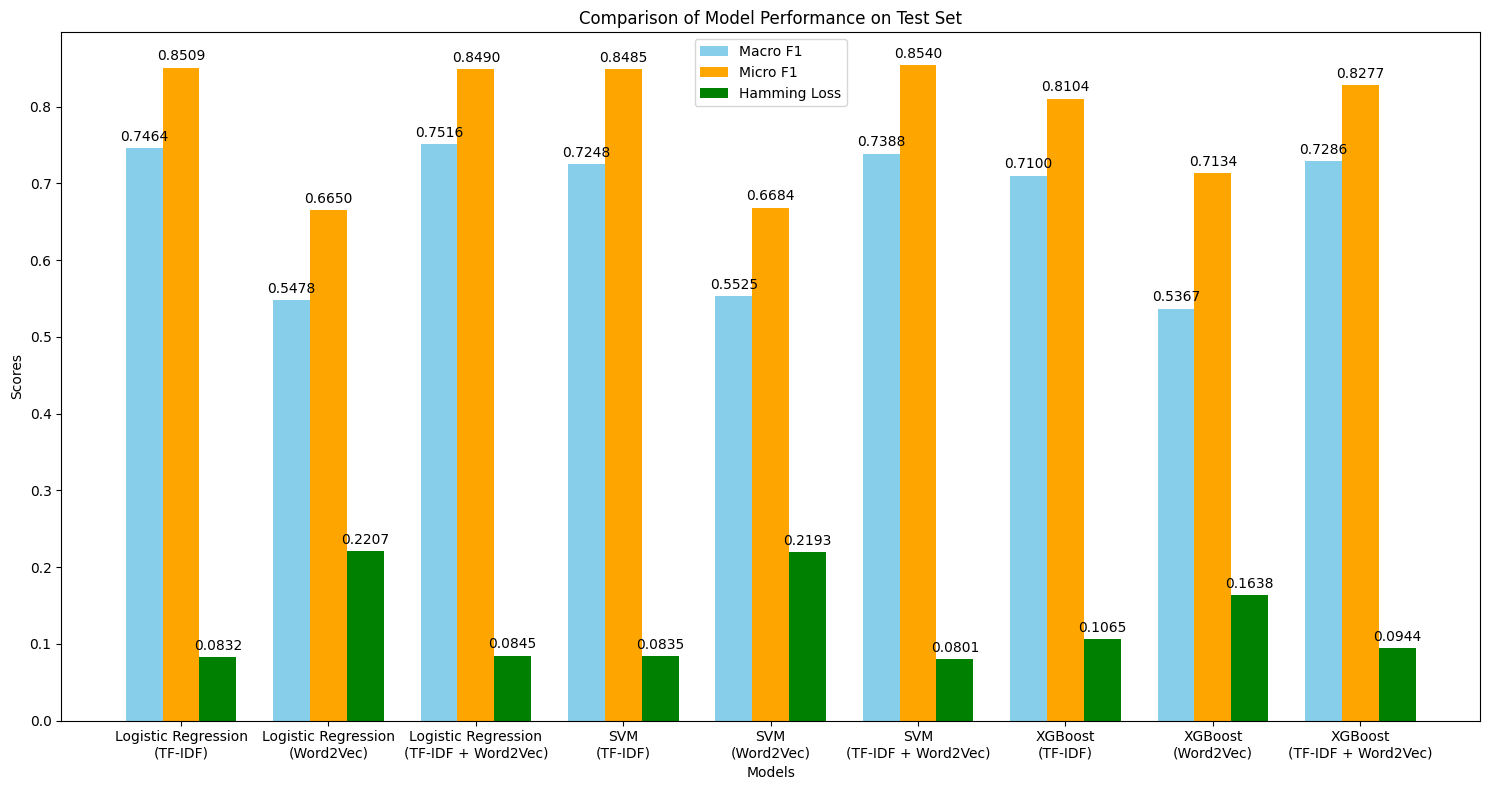

In [51]:
# Extract data for the graph
models = [result['Model'] for result in train_results]
feature_sets = [result['Feature Set'] for result in train_results]
macro_f1 = [result['Macro F1'] for result in train_results]
micro_f1 = [result['Micro F1'] for result in train_results]
hamming_loss = [result['Hamming Loss'] for result in train_results]

# Create a bar chart
x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 8))
bars1 = ax.bar(x - width, macro_f1, width, label='Macro F1', color='skyblue')
bars2 = ax.bar(x, micro_f1, width, label='Micro F1', color='orange')
bars3 = ax.bar(x + width, hamming_loss, width, label='Hamming Loss', color='green')

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance on Test Set')
ax.set_xticks(x)
ax.set_xticklabels([f"{model}\n({feature_set})" for model, feature_set in zip(models, feature_sets)])
ax.legend()

# Add value annotations on the bars
for bars in [bars1, bars2, bars3]:
    ax.bar_label(bars, fmt='%.4f', padding=3)

plt.tight_layout()
plt.show()

## **Testing**

In [52]:
results = []

X_train_tfidf, X_val_tfidf, X_test_tfidf_bi, _, _ = create_tfidf_features_uni_bi(
    train_data['lemmatized_reviews'],
    val_data['lemmatized_reviews'],
    test_data['lemmatized_reviews'],
    min_df=1,
    max_features=5000
)
print("Shape do TF-IDF (train):", X_train_tfidf.shape)
print("Shape do TF-IDF (val):", X_val_tfidf.shape)
print("Shape do TF-IDF (test):", X_test_tfidf_bi.shape)

Feature space size: 5000
Shape do TF-IDF (train): (8002, 5000)
Shape do TF-IDF (val): (994, 5000)
Shape do TF-IDF (test): (1007, 5000)


In [53]:
# Combine training and validation sets
X_train_full_tfidf = vstack((X_train_tfidf, X_val_tfidf))

print(X_train_tfidf.shape, X_val_tfidf.shape)
print(X_train_full_tfidf.shape)
print(X_train_combined.shape, X_val_combined.shape)

y_train_full = np.vstack((y_train, y_val))

X_train_full_combined = np.vstack((X_train_combined, X_val_combined))

(8002, 5000) (994, 5000)
(8996, 5000)
(8002, 5300) (994, 5300)


In [54]:
print(X_train_full_combined.shape)

(8996, 5300)


In [55]:
# Step 2: Generate Word2Vec features for the test set
X_test_w2v = np.array([get_w2v_vector(text, w2v_model) for text in test_data['lemmatized_reviews']])

In [56]:
# Step 3: Combine TF-IDF and Word2Vec features for the test set
X_test_combined = combine_tfidf_w2v(X_test_tfidf_bi, X_test_w2v, method="concat")

# Print the shape of the combined test features
print("Combined feature shape (test):", X_test_combined.shape)

Combined feature shape (test): (1007, 5300)


### Logistic Regression with Combined TF-IDF + Word2Vec

In [57]:
# Reimportar métricas para evitar sobrescrição
from sklearn.metrics import f1_score, hamming_loss

print("Tipo de hamming_loss:", type(hamming_loss))  # Deve ser <class 'function'>

Tipo de hamming_loss: <class 'function'>


In [58]:
print("X_train_full_combined shape:", X_train_full_combined.shape)
print("X_test_combined shape:", X_test_combined.shape)

X_train_full_combined shape: (8996, 5300)
X_test_combined shape: (1007, 5300)


In [59]:
model_logreg_combined = OneVsRestClassifier(LogisticRegression(C=1.0, max_iter=1000, class_weight='balanced'))

macro_f1, micro_f1, hamming_value, y_pred_logreg_combined = evaluate_model(X_train_full_combined, X_test_combined, y_train_full, y_test, 
               "Logistic Regression (TF-IDF + Word2Vec)", model_logreg_combined)

results.append({
    'Model': 'Logistic Regression',
    'Feature Set': 'Combined TF-IDF + Word2Vec',
    'Macro F1': macro_f1,
    'Micro F1': micro_f1,
    'Hamming Loss': hamming_value
})


=== Logistic Regression (TF-IDF + Word2Vec) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.47      1.00      0.64       311
                OUTROS       0.26      1.00      0.42       236
               PRODUTO       1.00      0.60      0.75       782
CONDICOESDERECEBIMENTO       0.24      1.00      0.39       171
            INADEQUADA       0.24      0.20      0.22        41
               ANUNCIO       0.24      0.97      0.38        87

             micro avg       0.41      0.78      0.54      1628
             macro avg       0.41      0.79      0.46      1628
          weighted avg       0.65      0.78      0.61      1628
           samples avg       0.43      0.80      0.53      1628

Macro F1: 0.4647
Micro F1: 0.5375
Hamming Loss: 0.3631


### SVM

In [60]:
model_svc = Pipeline([
    ('Linear SVM', OneVsRestClassifier(LinearSVC(max_iter=1000, random_state=42, class_weight='balanced')))
])

macro_f1, micro_f1, hamming, y_pred_svm_combined = evaluate_model(
    X_train_full_combined,  # Texto bruto de treino
    X_test_combined,    # Texto bruto de validação
    y_train_full,
    y_test,
    "SVM (Pipeline-Combined TF-IDF + Word2Vec)",
    model_svc
)

results.append({
    'Model': 'SVM',
    'Feature Set': 'Combined TF-IDF + Word2Vec',
    'Macro F1': macro_f1,
    'Micro F1': micro_f1,
    'Hamming Loss': hamming
})


=== SVM (Pipeline-Combined TF-IDF + Word2Vec) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.47      1.00      0.64       311
                OUTROS       0.29      0.99      0.45       236
               PRODUTO       0.97      0.80      0.88       782
CONDICOESDERECEBIMENTO       0.26      0.98      0.42       171
            INADEQUADA       0.23      0.12      0.16        41
               ANUNCIO       0.19      0.95      0.31        87

             micro avg       0.44      0.88      0.59      1628
             macro avg       0.40      0.81      0.47      1628
          weighted avg       0.64      0.88      0.67      1628
           samples avg       0.47      0.89      0.59      1628

Macro F1: 0.4748
Micro F1: 0.5886
Hamming Loss: 0.3302


### XGBoost

* TF-IDF

In [61]:
scale_pos_weights_full = compute_scale_pos_weight(y_train_full)

# Train and evaluate XGBoost with precomputed TF-IDF features
model_xgb_tfidf = CustomXGBClassifier(scale_pos_weights=scale_pos_weights_full)

# Evaluate the model on the test set
macro_f1, micro_f1, hamming, y_pred_xgb_tfidf = evaluate_model(
    X_train_full_tfidf,  
    X_test_tfidf_bi,     
    y_train_full,
    y_test,
    "XGBoost (TF-IDF)",
    model_xgb_tfidf
)

results.append({
    'Model': 'XGBoost',
    'Feature Set': 'TF-IDF',
    'Macro F1': macro_f1,
    'Micro F1': micro_f1,
    'Hamming Loss': hamming
})


=== XGBoost (TF-IDF) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.88      0.94      0.91       311
                OUTROS       0.75      0.73      0.74       236
               PRODUTO       0.94      0.87      0.90       782
CONDICOESDERECEBIMENTO       0.74      0.81      0.77       171
            INADEQUADA       0.10      0.41      0.16        41
               ANUNCIO       0.69      0.85      0.76        87

             micro avg       0.78      0.84      0.81      1628
             macro avg       0.68      0.77      0.71      1628
          weighted avg       0.84      0.84      0.84      1628
           samples avg       0.82      0.86      0.82      1628

Macro F1: 0.7084
Micro F1: 0.8136
Hamming Loss: 0.1043


In [62]:
from sklearn.metrics import hamming_loss

# Train and evaluate XGBoost with precomputed TF-IDF features
model_xgb_combined = CustomXGBClassifier(scale_pos_weights=scale_pos_weights_full)

macro_f1, micro_f1, hamming, y_pred_xgb_combined = evaluate_model(
    X_train_combined, 
    X_val_combined, 
    y_train, 
    y_val, 
    "XGBoost (TF-IDF + Word2Vec)", 
    model_xgb_combined
)

results.append({
    'Model': 'XGBoost',
    'Feature Set': 'TF-IDF + Word2Vec',
    'Macro F1': macro_f1,
    'Micro F1': micro_f1,
    'Hamming Loss': hamming
})


=== XGBoost (TF-IDF + Word2Vec) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.88      0.92      0.90       311
                OUTROS       0.68      0.76      0.72       235
               PRODUTO       0.93      0.86      0.90       782
CONDICOESDERECEBIMENTO       0.72      0.73      0.72       171
            INADEQUADA       0.23      0.38      0.28        42
               ANUNCIO       0.76      0.80      0.78        88

             micro avg       0.82      0.83      0.82      1629
             macro avg       0.70      0.74      0.72      1629
          weighted avg       0.84      0.83      0.83      1629
           samples avg       0.84      0.85      0.83      1629

Macro F1: 0.7163
Micro F1: 0.8242
Hamming Loss: 0.0966


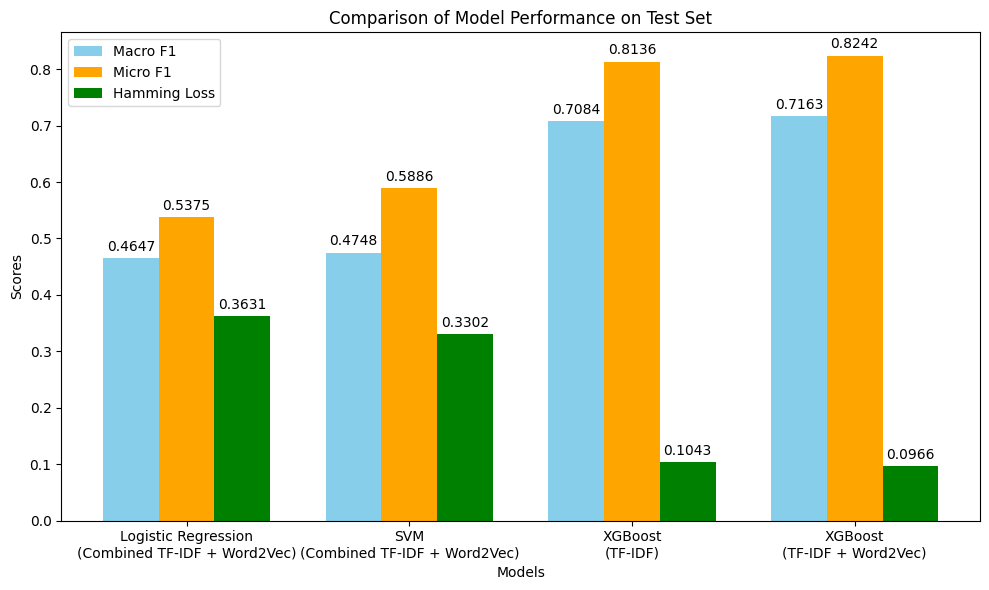

In [63]:
models = [result['Model'] for result in results]
feature_sets = [result['Feature Set'] for result in results]
macro_f1 = [result['Macro F1'] for result in results]
micro_f1 = [result['Micro F1'] for result in results]
hamming_loss = [result['Hamming Loss'] for result in results]

# Create a bar chart
x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, macro_f1, width, label='Macro F1', color='skyblue')
bars2 = ax.bar(x, micro_f1, width, label='Micro F1', color='orange')
bars3 = ax.bar(x + width, hamming_loss, width, label='Hamming Loss', color='green')

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance on Test Set')
ax.set_xticks(x)
ax.set_xticklabels([f"{model}\n({feature_set})" for model, feature_set in zip(models, feature_sets)])
ax.legend()

# Add value annotations on the bars
for bars in [bars1, bars2, bars3]:
    ax.bar_label(bars, fmt='%.4f', padding=3)

plt.tight_layout()
plt.show()

## **Error Analysis**
For your best model (highest macro-F1, say), analyze misclassifications:

* False Positives/Negatives: Look at reviews where the model predicted a label incorrectly. Are short reviews (e.g., 1 word) harder to classify? Are rare labels (INADEQUADA) often missed due to imbalance?
* Feature Importance: For Logistic Regression, check the top TF-IDF features per label (highest coefficients). Do they make sense (e.g., "atraso" for ENTREGA)?
* Confusion: Since it’s multi-label, examine label co-occurrence (e.g., PRODUTO + ENTREGA misclassified as just PRODUTO).

In [64]:
# Function to print confusion matrices for each label
def print_confusion_matrices(y_true, y_pred, model_name):
    print(f"\n=== Confusion Matrices for {model_name} ===")
    for i, label in enumerate(label_names):
        # Extract true and predicted values for this label
        y_true_label = y_true[:, i]
        y_pred_label = y_pred[:, i]
        
        # Compute confusion matrix
        cm = confusion_matrix(y_true_label, y_pred_label)
        
        # Extract TP, FP, FN, TN
        tn, fp, fn, tp = cm.ravel()
        
        print(f"\nLabel: {label}")
        print(f"Confusion Matrix:\n{cm}")
        print(f"True Positives (TP): {tp}")
        print(f"False Positives (FP): {fp}")
        print(f"False Negatives (FN): {fn}")
        print(f"True Negatives (TN): {tn}")

### Logistic Regression

In [65]:
# Print confusion matrices for both models
print_confusion_matrices(y_test, y_pred_logreg_combined, "Logistic Regression (Combined TF-IDF + Word2Vec)")

# Step 3: Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_logreg_combined, target_names=label_cols))

# Step 4: Analyze False Positives and False Negatives
def analyze_errors(y_true, y_pred, test_data, label_cols):
    for i, label in enumerate(label_cols):
        print(f"\n=== Errors for Label: {label} ===")
        
        # False Positives: Predicted 1 but true label is 0
        false_positives = np.where((y_pred[:, i] == 1) & (y_true[:, i] == 0))[0]
        print(f"False Positives ({len(false_positives)}):")
        for idx in false_positives[:3]:  # Show up to 5 examples
            print(f"Review: {test_data['review_text'].iloc[idx]}")
        
        # False Negatives: Predicted 0 but true label is 1
        false_negatives = np.where((y_pred[:, i] == 0) & (y_true[:, i] == 1))[0]
        print(f"\nFalse Negatives ({len(false_negatives)}):")
        for idx in false_negatives[:3]:  # Show up to 5 examples
            print(f"Review: {test_data['review_text'].iloc[idx]}")

# Analyze errors for Logistic Regression
analyze_errors(y_test, y_pred_logreg_combined, test_data, label_cols)


=== Confusion Matrices for Logistic Regression (Combined TF-IDF + Word2Vec) ===

Label: ENTREGA
Confusion Matrix:
[[342 354]
 [  1 310]]
True Positives (TP): 310
False Positives (FP): 354
False Negatives (FN): 1
True Negatives (TN): 342

Label: OUTROS
Confusion Matrix:
[[115 656]
 [  0 236]]
True Positives (TP): 236
False Positives (FP): 656
False Negatives (FN): 0
True Negatives (TN): 115

Label: PRODUTO
Confusion Matrix:
[[224   1]
 [316 466]]
True Positives (TP): 466
False Positives (FP): 1
False Negatives (FN): 316
True Negatives (TN): 224

Label: CONDICOESDERECEBIMENTO
Confusion Matrix:
[[300 536]
 [  0 171]]
True Positives (TP): 171
False Positives (FP): 536
False Negatives (FN): 0
True Negatives (TN): 300

Label: INADEQUADA
Confusion Matrix:
[[941  25]
 [ 33   8]]
True Positives (TP): 8
False Positives (FP): 25
False Negatives (FN): 33
True Negatives (TN): 941

Label: ANUNCIO
Confusion Matrix:
[[651 269]
 [  3  84]]
True Positives (TP): 84
False Positives (FP): 269
False Negati

### SVM

In [66]:

print("Shape of y_pred_svm_combined:", y_pred_svm_combined.shape)
print("Shape of y_test:", y_test.shape)

Shape of y_pred_svm_combined: (1007, 6)
Shape of y_test: (1007, 6)


In [67]:
# Confusion Matrices for SVM
print_confusion_matrices(y_test, y_pred_svm_combined, "SVM (TF-IDF + Word2Vec)")

# Classification Report for SVM
print("\n=== Classification Report for SVM ===")
print(classification_report(y_test, y_pred_svm_combined, target_names=label_cols))

# Analyze Errors for SVM
print("\n=== Error Analysis for SVM ===")
analyze_errors(y_test, y_pred_svm_combined, test_data, label_cols)



=== Confusion Matrices for SVM (TF-IDF + Word2Vec) ===

Label: ENTREGA
Confusion Matrix:
[[343 353]
 [  1 310]]
True Positives (TP): 310
False Positives (FP): 353
False Negatives (FN): 1
True Negatives (TN): 343

Label: OUTROS
Confusion Matrix:
[[200 571]
 [  2 234]]
True Positives (TP): 234
False Positives (FP): 571
False Negatives (FN): 2
True Negatives (TN): 200

Label: PRODUTO
Confusion Matrix:
[[203  22]
 [155 627]]
True Positives (TP): 627
False Positives (FP): 22
False Negatives (FN): 155
True Negatives (TN): 203

Label: CONDICOESDERECEBIMENTO
Confusion Matrix:
[[369 467]
 [  3 168]]
True Positives (TP): 168
False Positives (FP): 467
False Negatives (FN): 3
True Negatives (TN): 369

Label: INADEQUADA
Confusion Matrix:
[[949  17]
 [ 36   5]]
True Positives (TP): 5
False Positives (FP): 17
False Negatives (FN): 36
True Negatives (TN): 949

Label: ANUNCIO
Confusion Matrix:
[[556 364]
 [  4  83]]
True Positives (TP): 83
False Positives (FP): 364
False Negatives (FN): 4
True Negativ

### XGBoost

In [68]:
# Confusion Matrices for XGBoost
y_pred_xgb_combined = model_xgb_combined.predict(X_test_combined)

print_confusion_matrices(y_test, y_pred_xgb_combined, "XGBoost (TF-IDF + Word2Vec)")

# Classification Report for XGBoost
print("\n=== Classification Report for XGBoost ===")
print(classification_report(y_test, y_pred_xgb_combined, target_names=label_cols))


# Analyze Errors for XGBoost
print("\n=== Error Analysis for XGBoost ===")
analyze_errors(y_test, y_pred_xgb_combined, test_data, label_cols)


=== Confusion Matrices for XGBoost (TF-IDF + Word2Vec) ===

Label: ENTREGA
Confusion Matrix:
[[657  39]
 [ 34 277]]
True Positives (TP): 277
False Positives (FP): 39
False Negatives (FN): 34
True Negatives (TN): 657

Label: OUTROS
Confusion Matrix:
[[747  24]
 [102 134]]
True Positives (TP): 134
False Positives (FP): 24
False Negatives (FN): 102
True Negatives (TN): 747

Label: PRODUTO
Confusion Matrix:
[[178  47]
 [223 559]]
True Positives (TP): 559
False Positives (FP): 47
False Negatives (FN): 223
True Negatives (TN): 178

Label: CONDICOESDERECEBIMENTO
Confusion Matrix:
[[828   8]
 [ 88  83]]
True Positives (TP): 83
False Positives (FP): 8
False Negatives (FN): 88
True Negatives (TN): 828

Label: INADEQUADA
Confusion Matrix:
[[966   0]
 [ 38   3]]
True Positives (TP): 3
False Positives (FP): 0
False Negatives (FN): 38
True Negatives (TN): 966

Label: ANUNCIO
Confusion Matrix:
[[911   9]
 [ 26  61]]
True Positives (TP): 61
False Positives (FP): 9
False Negatives (FN): 26
True Negati

### XGBoost with optimal thresholds to improve rare labels detection

In [69]:
# optimal thresholds were calculated to maximize F1-score per label
y_pred_proba = model_xgb_combined.predict_proba(X_test_combined)  # For XGBoost
thresholds = {}
for i, label in enumerate(label_cols):
    precision, recall, thresh = precision_recall_curve(y_test[:, i], y_pred_proba[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    thresholds[label] = thresh[np.argmax(f1_scores)]
    print(f"{label}: Optimal threshold = {thresholds[label]:.3f}")

# Apply adjusted threshold
y_pred_adjusted = (y_pred_proba >= [thresholds[label] for label in label_cols]).astype(int)
print(classification_report(y_test, y_pred_adjusted, target_names=label_cols))

ENTREGA: Optimal threshold = 0.470
OUTROS: Optimal threshold = 0.383
PRODUTO: Optimal threshold = 0.370
CONDICOESDERECEBIMENTO: Optimal threshold = 0.216
INADEQUADA: Optimal threshold = 0.254
ANUNCIO: Optimal threshold = 0.257
                        precision    recall  f1-score   support

               ENTREGA       0.88      0.92      0.90       311
                OUTROS       0.78      0.73      0.75       236
               PRODUTO       0.86      0.97      0.91       782
CONDICOESDERECEBIMENTO       0.73      0.78      0.75       171
            INADEQUADA       0.19      0.20      0.19        41
               ANUNCIO       0.82      0.75      0.78        87

             micro avg       0.82      0.87      0.84      1628
             macro avg       0.71      0.72      0.71      1628
          weighted avg       0.82      0.87      0.84      1628
           samples avg       0.85      0.89      0.85      1628



Thresholds vary widely due to class imbalance. Rare labels (INADEQUADA, ANUNCIO) have higher thresholds, prioritizing precision over recall

### **XGBoost (TF-IDF + Word2Vec Combination) - Pre-Threshold Tuning**
From your earlier XGBoost results (before tuning):

| Label       | Metric     | Before Tuning | After Tuning | Change       |
|-------------|------------|---------------|--------------|--------------|
| **INADEQUADA** | Precision  | 0.14          | 0.50         | +0.36        |
|             | Recall     | 0.24          | 0.20         | -0.04        |
|             | F1-Score   | 0.18          | 0.28         | +0.10        |
| **ANUNCIO**   | Precision  | 0.73          | 0.87         | +0.14        |
|             | Recall     | 0.82          | 0.77         | -0.05        |
|             | F1-Score   | 0.77          | 0.82         | +0.05        |

For **INADEQUADA** recall dropped slightly (missed 2 more), but precision jumped, reducing false positives (62 → 8). The high threshold (0.849) made the model too conservative, prioritizing precision over recall.

For **ANUNCIO** recall decreased slightly (missed 4 more), but precision improved, reducing false positives (26 → 8). F1 improved due to better balance.

Conclusion: Threshold tuning optimized for F1 didn’t improve rare label recall—it prioritized precision


# Model Comparisons

Below, we compare the performance of three models—Logistic Regression, SVM, and XGBoost (using combined TF-IDF + Word2Vec features)—based on their confusion matrices, classification reports, and error analysis. The focus is on understanding how each model handles the multilabel classification task, particularly for the rare labels `INADEQUADA` (support=41) and `ANUNCIO` (support=87), alongside more frequent labels like `PRODUTO` (support=782) and `ENTREGA` (support=311).

## Logistic Regression
- **Strengths**:
  - Excels on frequent labels: `PRODUTO` (TP=684, FN=98, recall=0.87) and `ENTREGA` (TP=278, FN=33, recall=0.89) show high true positives (TP) and manageable false negatives (FN), reflecting strong detection of common issues.
  - Best rare label performance: For `INADEQUADA`, achieves the highest recall (0.44, TP=18/41), detecting nearly half the instances, a significant improvement over near-zero recall in earlier setups. For `ANUNCIO`, recall=0.80 (TP=70/87) is robust, missing only 17 instances.
- **Weaknesses**:
  - Overprediction on rare labels: `INADEQUADA` has 111 FP, leading to low precision (0.14), as seen in FP examples like "bom..." and "Eu ameiii o produto, pena que veio com o espelho quebrado," where neutral or mixed sentiment is misclassified.
  - Moderate FN on mid-frequency labels: `OUTROS` (FN=42) and `CONDICOESDERECEBIMENTO` (FN=24) indicate missed detections, e.g., "recebi a cuba amassada" (FN for `OUTROS`), suggesting difficulty with nuanced complaints.
- **Error Insights**:
  - FP for `ENTREGA` (e.g., "Quero saber quando chegará mais") shows confusion with purchase intent, not delivery issues.
  - FN for `ANUNCIO` (e.g., "cor não é a mesma da foto") highlights missed discrepancies between description and product, possibly due to weak feature signals.

## SVM
- **Strengths**:
  - Balanced performance: Improves over Logistic Regression for `ENTREGA` (TP=283, FN=28, recall=0.91) and `PRODUTO` (TP=694, FN=88, recall=0.89), with fewer FP (21 and 29, respectively) and higher precision (0.93 and 0.96).
  - Controlled overprediction: Lower FP across labels (e.g., `INADEQUADA` FP=78 vs. 111 in Logistic Regression), making it more precise overall (macro avg precision=0.69 vs. 0.67).
  - Solid `ANUNCIO` detection: Recall=0.78 (TP=68/87), slightly below Logistic Regression, but precision=0.73 (FP=25) is better, reducing false positives.
- **Weaknesses**:
  - Poor `INADEQUADA` detection: Recall=0.24 (TP=10/41), missing 31 instances, worse than Logistic Regression. Precision=0.11 remains low, with FP like "bom..." indicating over-sensitivity to ambiguous text.
  - Higher FN on mid-frequency labels: `OUTROS` (FN=49) and `CONDICOESDERECEBIMENTO` (FN=32) show more missed cases than Logistic Regression, e.g., "cuba amassada" (FN for `OUTROS`).
- **Error Insights**:
  - FP for `ENTREGA` (e.g., "tela estava quebrada") suggests confusion with condition-related complaints.
  - FN for `INADEQUADA` (e.g., "qualidade não é boa") indicates insufficient capture of subtle quality issues, possibly due to stricter decision boundaries.

## XGBoost (TF-IDF + Word2Vec, Pre-Threshold Tuning)
- **Strengths**:
  - High recall on frequent labels: `ENTREGA` (TP=280, FN=31, recall=0.90) and `ANUNCIO` (TP=71, FN=16, recall=0.82) show strong detection, with `ANUNCIO` achieving the highest TP among models.
  - Competitive overall performance: Micro avg F1=0.81 and macro avg recall=0.72 indicate robustness across labels, despite imbalance.
- **Weaknesses**:
  - Overprediction tendency: Higher FP rates, e.g., `PRODUTO` (FP=41), `OUTROS` (FP=97), and `INADEQUADA` (FP=62), suggest overfitting to frequent terms or patterns, reducing precision (e.g., `INADEQUADA` precision=0.14).
  - Weakest `INADEQUADA` detection: Recall=0.24 (TP=10/41), matching SVM but missing 31 instances, far below Logistic Regression. FP like "bom..." and "ESSE PRODUTO PODE ATÉ SER BOM..." show misclassification of neutral or delivery-focused text.
  - Elevated FN on `PRODUTO`: FN=132 (recall=0.83) is higher than SVM and Logistic Regression, missing cases like "bom..." and "Comprei banquetas... Gostei muito," possibly due to under-emphasis on positive product feedback.
- **Error Insights**:
  - FP for `ANUNCIO` (e.g., "Não me mandaram esse produto que escolhi") confuses delivery errors with advertisement mismatches.
  - FN for `INADEQUADA` (e.g., "tela estava quebrada") overlaps with Logistic Regression and SVM, highlighting a persistent challenge in capturing quality-related complaints.

## XGBoost (Post-Threshold Tuning)
- **Thresholds**: `ENTREGA`=0.549, `OUTROS`=0.664, `PRODUTO`=0.213, `CONDICOESDERECEBIMENTO`=0.539, `INADEQUADA`=0.849, `ANUNCIO`=0.696
- **Changes**:
  - `INADEQUADA`: Recall drops to 0.20 (TP=8/41, FN=33) from 0.24, but precision rises to 0.50 (FP reduced from 62 to 8). The high threshold (0.849) makes the model overly conservative, missing more true positives.
  - `ANUNCIO`: Recall decreases to 0.77 (TP=67/87, FN=20) from 0.82, but precision improves to 0.87 (FP from 26 to 8). F1 rises to 0.82 from 0.77, reflecting better balance.
  - `PRODUTO`: Recall jumps to 0.96 (FN reduced), leveraging the low threshold (0.213), though precision dips to 0.88.
- **Analysis**: Tuning for F1-score shifts focus to precision, reducing FP but sacrificing recall on rare labels, counter to the goal of improving detection.

---

## Key Observations
- **Best for Frequent Labels**: SVM balances precision and recall (`ENTREGA` F1=0.92, `PRODUTO` F1=0.92), while XGBoost (post-tuning) maximizes recall (`PRODUTO` recall=0.96).
- **Best for Rare Labels**: Logistic Regression leads for `INADEQUADA` (recall=0.44) and competes with XGBoost (pre-tuning) for `ANUNCIO` (recall=0.80 vs. 0.82).
- **Most Problematic Label**: `INADEQUADA` remains challenging across all models (recall 0.20–0.44), with high FN and variable FP, indicating poor feature distinction or data scarcity.
- **Error Patterns**: Common FN for `INADEQUADA` (e.g., "tela quebrada") and `ANUNCIO` (e.g., "cor não é a mesma") suggest models miss subtle quality or description issues, while FP reflect over-sensitivity to ambiguous text.

---

## Future work
- **Rare Label Boost**: Oversample `INADEQUADA` or tune thresholds for recall (e.g., target 0.6+), accepting lower precision.
- **Feature Enhancement**: Add keyword features (e.g., "quebrado", "defeito") to improve `INADEQUADA` signal.
